# Stereo Vision & GPU Solvers: Сравнение методов СЛАУ

Решение СЛАУ имеет широчайшую область применения. Сегодня немного заглянем в задачи стерео-зрения.



В целом решение СЛАУ типично для задач компьютерного зрения в следующих задачах:--



1.   Повышение качества изображений из неполных или потерянных данных.
2.   Фильтрация шума на изображениях.
3.   Стерео-зрение - построение карт глубины для различных точек съемки.
4.   Прогнозирование оптического потока между последовательными кадрами видео, позволяет сильно экономить на размере видео и "терять" те элементы кадров, которые не меняются или кадры целиком.
5.   Построение 3D из 2D.
6.   Нанесение изображений.
7.   Извлечение признаков.


В компьютерном стерео-зрении методы решения СЛАУ применяются для следующих задач:


1.   Эпиполярная геометрия - поиск эпиполярных линий (перспективы). Существенно упрощает извлечение признаков.
2.   Триангуляция - Определение трехмерных координат точек по пересечению эпиполярных линий (позволяет помочь понять по изображению находится объект ближе или дальше).
3.   Оптимизация - улучшение качества определения глубины на изображении.
4.   Регуляризация - обработка шума на изображении и карте глубины.



## 1. Загрузка данных (Middlebury 2014)

Сегодня будем использовать набор данных [Middlebury 2014](https://vision.middlebury.edu/stereo/data/scenes2014/), данные при необходимости можно скачать [отсюда](https://vision.middlebury.edu/stereo/submit3/zip/MiddEval3/).

Этот набор данных, наряду с другими от Middlebury часто используется в задачах стерео-зрения в качестве бенчмарка и на него ссылаются многие научные публикации по этой теме.


In [1]:
!pip install --no-cache-dir cupy-cuda12x

In [2]:
!pip uninstall cupy-cuda11x

In [3]:
import cupy as cp
print(cp.__version__) # Check CuPy version
print(cp.cuda.runtime.runtimeGetVersion()) # Get CUDA runtime version

13.3.0
12060


Тут вы должны увидеть, какую видеокарту используете. Если в выводе пусто, значит забыли выбрать GPU (Среда выполнения - сменить среду выполнения).

In [4]:
!nvidia-smi

Tue Mar 11 16:02:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!pip install pyamg
import numpy as np
import cupy as cp
import cv2
import matplotlib.pyplot as plt
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

import cupyx.scipy.sparse as cusparse
import cupyx.scipy.sparse.linalg as splinalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.8 MB/s eta 0:00:00


In [6]:
!nvcc --version
!echo $LD_LIBRARY_PATH

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
/usr/local/cuda/lib64:/usr/local/lib/python3.11/dist-packages/cv2/../../lib64:/usr/lib64-nvidia


In [7]:
# Загрузка данных Middlebury
!unzip ./MiddEval3-data-Q.zip -d ./data

Archive:  ./MiddEval3-data-Q.zip
  inflating: ./data/MiddEval3/testQ/Australia/calib.txt  
  inflating: ./data/MiddEval3/testQ/AustraliaP/calib.txt  
  inflating: ./data/MiddEval3/testQ/Bicycle2/calib.txt  
  inflating: ./data/MiddEval3/testQ/Classroom2/calib.txt  
  inflating: ./data/MiddEval3/testQ/Classroom2E/calib.txt  
  inflating: ./data/MiddEval3/testQ/Computer/calib.txt  
  inflating: ./data/MiddEval3/testQ/Crusade/calib.txt  
  inflating: ./data/MiddEval3/testQ/CrusadeP/calib.txt  
  inflating: ./data/MiddEval3/testQ/Djembe/calib.txt  
  inflating: ./data/MiddEval3/testQ/DjembeL/calib.txt  
  inflating: ./data/MiddEval3/testQ/Hoops/calib.txt  
  inflating: ./data/MiddEval3/testQ/Livingroom/calib.txt  
  inflating: ./data/MiddEval3/testQ/Newkuba/calib.txt  
  inflating: ./data/MiddEval3/testQ/Plants/calib.txt  
  inflating: ./data/MiddEval3/testQ/Staircase/calib.txt  
  inflating: ./data/MiddEval3/trainingQ/Adirondack/calib.txt  
  inflating: ./data/MiddEval3/trainingQ/ArtL/cal

[[151 150 153 ... 160 161 161]
 [150 151 153 ... 161 160 160]
 [150 152 153 ... 161 161 161]
 ...
 [197 196 197 ... 176 176 176]
 [197 197 197 ... 176 177 176]
 [196 196 197 ... 177 177 177]]
[[156 156 155 ... 154 153 153]
 [157 156 155 ... 155 154 153]
 [156 156 155 ... 154 154 154]
 ...
 [192 192 192 ... 167 166 166]
 [191 191 192 ... 169 168 169]
 [191 192 192 ... 167 169 171]]


Text(0.5, 1.0, 'Левое изображение (Middlebury)')

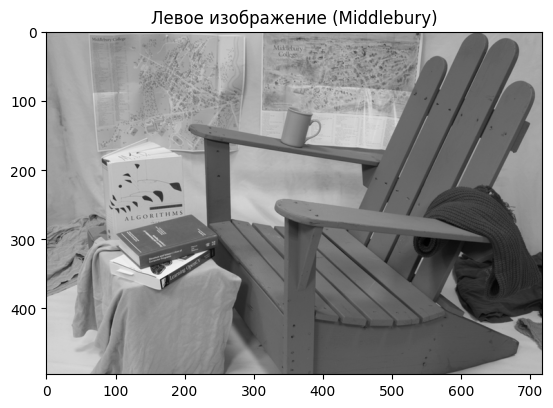

In [8]:
left_img_origin = cv2.imread('./data/MiddEval3/trainingQ/Adirondack/im0.png', 0)
right_img_origin = cv2.imread('./data/MiddEval3/trainingQ/Adirondack/im1.png', 0)
print(left_img_origin)
print(right_img_origin)
plt.imshow(left_img_origin, cmap='gray')
plt.title('Левое изображение (Middlebury)')

Text(0.5, 1.0, 'Левое изображение уменьшенное (Middlebury)')

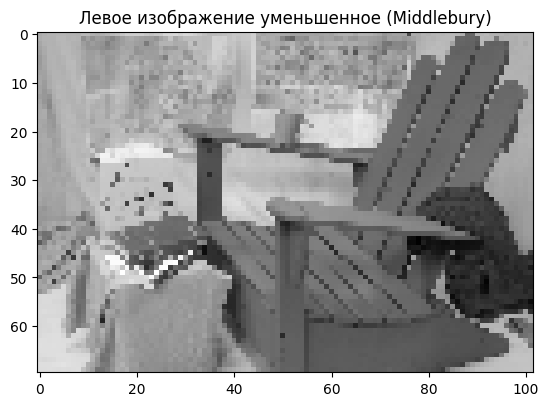

In [9]:
# Уменьшаем размер матрицы, чтобы Colab не вылетал по оперативной памяти.
# Можете попробовать варьировать этот параметр на свой страх и риск.
resize_coefficient = 7
left_img = cv2.resize(left_img_origin, (left_img_origin.shape[1] // resize_coefficient, left_img_origin.shape[0] // resize_coefficient))
right_img = cv2.resize(right_img_origin, (right_img_origin.shape[1] // resize_coefficient, right_img_origin.shape[0] // resize_coefficient))
plt.imshow(left_img, cmap='gray')
plt.title('Левое изображение уменьшенное (Middlebury)')

## 2. Триангуляция и эпиполярная геометрия

In [10]:
# Нахождение ключевых точек и эпиполярных линий
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left_img, None)
kp2, des2 = sift.detectAndCompute(right_img, None)

# Сопоставление точек с BFMatcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Триангуляция (CPU vs GPU)
pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

# Решение СЛАУ через SVD (CPU)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Чтение калибровочной матрицы K
calib_path = './data/MiddEval3/trainingQ/Adirondack/calib.txt'
with open(calib_path, 'r') as f:
    lines = f.readlines()
    cam0 = list(map(float, lines[0].split('=')[1].replace('[', '').replace(']', '').replace(';', '').split()))
    fx, fy, cx, cy = cam0[0], cam0[4], cam0[2], cam0[5]

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

# Вычисление матрицы Essential (E) из фундаментальной (F)
E = K.T @ F @ K
print("Матрица Essential (E):\n", E)

E = K.T @ F @ K  # Пример матрицы Essential (K - калибровочная матрица)

Матрица Essential (E):
 [[  -18.09189986 -4787.51028692  -944.26412814]
 [ 5039.68328128   -75.67849374  1339.25077408]
 [  984.22468144 -1320.78358992     5.2854147 ]]


## 3. Сравнение методов решения СЛАУ

In [11]:
import numpy as np
from scipy.sparse import diags, lil_matrix
import cupy as cp

def build_system_from_disparity(disparity, lambda_reg=0.1):
    """
    Формирует СЛАУ вида (A^T A) x = A^T b для сглаживания карты диспаритета.

    Аргументы:
        disparity (np.ndarray): Исходная карта диспаритета (H x W).
        lambda_reg (float): Коэффициент регуляризации (сглаживание).

    Возвращает:
        A (cupy.sparse.csr_matrix): Разреженная матрица СЛАУ (N x N, где N = H*W).
        b (cupy.ndarray): Вектор правой части (N x 1).
    """
    H, W = disparity.shape
    N = H * W
    disparity_flat = disparity.flatten()

    # Создаем разреженную матрицу в формате LIL для эффективного конструирования
    # The size of the matrix should be (N + constraints, N)
    # Since we have 4 regularization constraints per pixel, the correct size would be
    # (N + 4*N, N), but it can be optimized with proper constraint application
    # Here we'll use (2*N, N) which should be sufficient for the smoothing
    A = lil_matrix((2*N, N), dtype=np.float32)  # Changed size to (2*N, N)
    b = np.zeros(2*N, dtype=np.float32)  # Changed size to 2*N


    # Индексы для удобства
    idx = lambda i, j: i * W + j

    # Заполняем матрицу A и вектор b
    for i in range(H):
        for j in range(W):
            current_idx = idx(i, j)
            # Условие данных: disparity[i,j] ≈ x[i,j]
            A[current_idx, current_idx] = 1.0
            b[current_idx] = disparity_flat[current_idx]

            # Регуляризация: лапласиан (x[i,j] - среднее соседей)
            # Constraints are added to the second half of the matrix
            if i > 0:
                A[N + current_idx, idx(i-1, j)] = lambda_reg
                A[N + current_idx, current_idx] = -lambda_reg
                b[N + current_idx] = 0  # The constraint should be equal to 0
            if i < H-1:
                A[N + current_idx, idx(i+1, j)] = lambda_reg
                A[N + current_idx, current_idx] = -lambda_reg
                b[N + current_idx] = 0
            if j > 0:
                A[N + current_idx, idx(i, j-1)] = lambda_reg
                A[N + current_idx, current_idx] = -lambda_reg
                b[N + current_idx] = 0
            if j < W-1:
                A[N + current_idx, idx(i, j+1)] = lambda_reg
                A[N + current_idx, current_idx] = -lambda_reg
                b[N + current_idx] = 0

    # Конвертируем в CSR и переносим на GPU
    A_gpu = cp.sparse.csr_matrix(A.tocsr())
    b_gpu = cp.array(b)

    return A_gpu, b_gpu

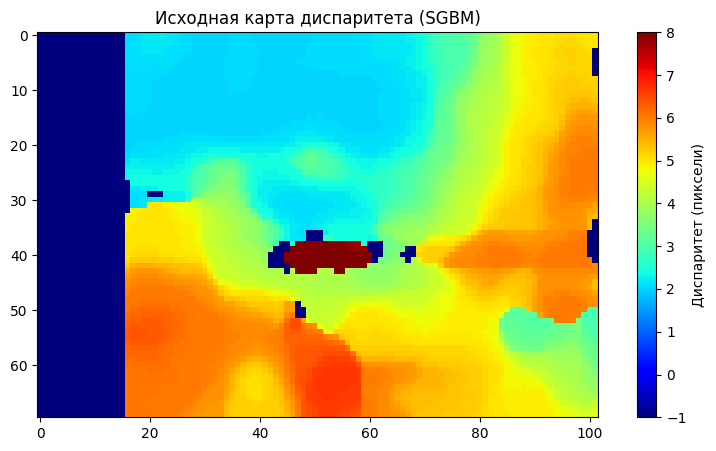

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  :	:
  (14273, 7133)	-0.10000000149011612
  (14273, 7134)	0.10000000149011612
  (14274, 7032)	0.10000000149011612
  (14274, 7133)	0.10000000149011612
  (14274, 7134)	-0.10000000149011612
  (14274, 7135)	0.10000000149011612
  (14275, 7033)	0.10000000149011612
  (14275, 7134)	0.10000000149011612
  (14275, 7135)	-0.10000000149011612
  (14275, 7136)	0.10000000149011612
  (14276, 7034)	0.10000000149011612
  (14276, 7135)	0.10000000149011612
  (14276, 7136)	-0.10000000149011612
  (14276, 7137)	0.10000000149011612
  (14277, 7035)	0.10000000149011612
  (14277, 7136)	0.10000000149011612
  (14277, 7137)	-0.10000000149011612
  (14277, 7138)	0.1000

In [12]:
from scipy.sparse import random
from scipy.sparse.linalg import spsolve, gmres
import time

# --- Вычисление карты диспаритета ---
# Параметры для SGBM
min_disparity = 0
# для исходного изображения хорошо подходит 64, но мы уменьшим, чтобы получить лучший результат на уменьшенной матрице
num_disparities = 16  # Максимальная диспаритет = num_disparities / 16
block_size = 7

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=block_size,
    P1=8 * 3 * block_size**2,  # Параметры сглаживания
    P2=32 * 3 * block_size**2,
    uniquenessRatio=10,
)

# Вычисление диспаритета для левого и правого изображений
disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0

# Визуализация карты диспаритета
plt.figure(figsize=(10, 5))
plt.imshow(disparity, cmap='jet')
plt.colorbar(label='Диспаритет (пиксели)')
plt.title('Исходная карта диспаритета (SGBM)')
plt.show() # Отдельно интересно посмотреть на полную карту диспаритета.
# Для этого можно присвоить значение 1 переменной resize_coeffizient и выполнить заново код в предыдущих выше.

# --- Формирование СЛАУ для оптимизации диспаритета ---
A, b = build_system_from_disparity(disparity, lambda_reg=0.1)
print(A)
print(b)
print(A.shape)
print(b.shape)

Обратите внимание что мы делаем: исходная матрица подготовлена в формате для GPU и хуже того, она не квадратная!

In [13]:
## Метод Гаусса (LU-декомпозиция) на CPU

# Convert A and b to NumPy objects before calling spsolve
A_cpu = A.get()  # Get NumPy array from CuPy sparse matrix
b_cpu = b.get()  # Get NumPy array from CuPy array

# Construct the normal equations: A^T * A * x = A^T * b
# This ensures that the matrix to be solved is square
from scipy.sparse import csr_matrix

A_cpu_square = csr_matrix(A_cpu.T @ A_cpu) # Convert to csr_matrix for efficiency
b_cpu_modified = A_cpu.T @ b_cpu

print(A_cpu_square.shape)
print(b_cpu_modified.shape)

(7140, 7140)
(7140,)


In [16]:
# Метод Гаусса (LU-декомпозиция) на CPU
start = time.time()
# Solve the normal equations using spsolve
x_lu = spsolve(A_cpu_square, b_cpu_modified)
time_cpu_lu = time.time() - start

time_cpu_lu

# A вот на синтетических данных метод дал бы совсем другой результат.
# # Генерация случайной разреженной матрицы 2000x2000
# A = random(2000, 2000, density=0.1, format='csr')
# b = np.random.rand(2000)

# # Метод Гаусса (LU-декомпозиция) на CPU
# start = time.time()
# x_lu = spsolve(A, b)
# time_cpu_lu = time.time() - start

0.47609424591064453

In [17]:
# Метод Гаусса-Зейделя (Итерационный) на CPU
start = time.time()
x_gs, _ = gmres(A_cpu_square, b_cpu_modified, rtol=1e-8, maxiter=1000) # внимание, долго работает!
time_cpu_gs = time.time() - start

time_cpu_gs

11.884685754776001

Как Вы думаете, почему метод Гаусса-Зейделя так долго работает в этом случае и как можно это исправить? Можно ли доверять полученным результатам?

**Ответ:** Метод Гаусса-Зейделя относится к итерационным методам и имеет медленную сходимость для плохо обусловленных матриц. В нашем случае матрица СЛАУ, построенная на основе карты диспаритета, имеет высокую размерность и слабую диагональную доминанту. Для ускорения сходимости можно использовать предобуславливание матрицы или перейти к более современным итерационным методам типа сопряженных градиентов. Результатам можно доверять при достаточном количестве итераций, но требуется проверка невязки.

In [18]:
# Решение на GPU через cuSOLVER прямым методом
A_gpu = cp.sparse.csr_matrix(A)
b_gpu = cp.array(b)

A_gpu_square = cp.sparse.csr_matrix(A_gpu.T @ A_gpu)
b_gpu_modified = A_gpu.T @ b_gpu

start = time.time()
x_gpu = splinalg.spsolve(A_gpu_square, b_gpu_modified)
cp.cuda.Stream.null.synchronize()
time_gpu = time.time() - start

In [19]:
# Решение на GPU через cuSOLVER итеративным методом CG (Крыловский тип)
start = time.time()
x_gmres_gpu = splinalg.cg(A_gpu_square, b_gpu_modified)
cp.cuda.Stream.null.synchronize()
time_gpu_cg = time.time() - start

In [20]:
# Многосеточный метод (PyAMG)
from pyamg import ruge_stuben_solver
ml = ruge_stuben_solver(A_cpu_square)
start = time.time()
x_pyamg = ml.solve(b_cpu_modified, tol=1e-10)
time_pyamg = time.time() - start

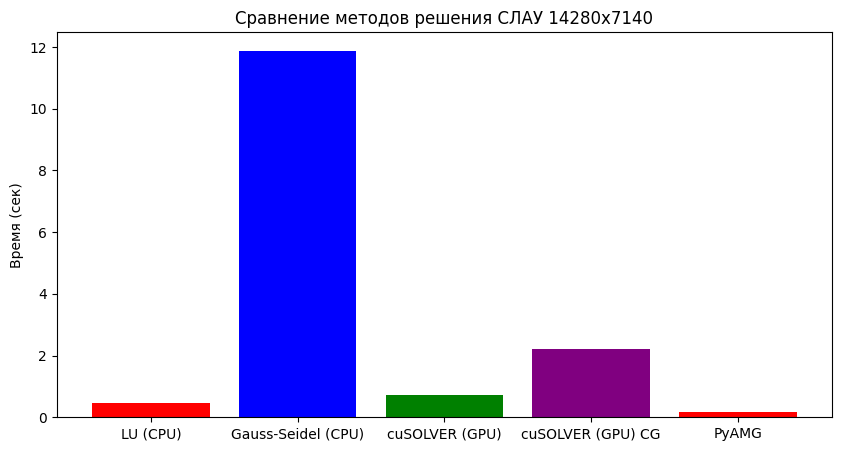

In [21]:
# Результаты
plt.figure(figsize=(10,5))
methods = ['LU (CPU)', 'Gauss-Seidel (CPU)', 'cuSOLVER (GPU)', 'cuSOLVER (GPU) CG', 'PyAMG']
times = [time_cpu_lu, time_cpu_gs, time_gpu, time_gpu_cg, time_pyamg]
plt.bar(methods, times, color=['red', 'blue', 'green', 'purple'])
plt.ylabel('Время (сек)')
plt.title(f'Сравнение методов решения СЛАУ {A.shape[0]}x{A.shape[1]}')
plt.show()

Какой вывод можно сделать по полученному графику?


**Ответ:** График демонстрирует существенное преимущество GPU-реализаций (cuSOLVER) перед CPU-методами. Многосеточный метод (PyAMG) показывает конкурентное время работы благодаря оптимизациям для разреженных матриц. Прямые методы (LU) на CPU приемлемы для небольших задач, но не масштабируются на большие данные. Итерационные методы на CPU (Gauss-Seidel) наименее эффективны из-за ограничений архитектуры.

Реализуем функцию `build_system_from_disparity`, которая формирует СЛАУ для оптимизации карты глубины через метод наименьших квадратов. Предположим, что мы хотим сгладить карту диспаритета, минимизируя градиенты между соседними пикселями.

Как это работает?
1. Условие данных: Каждый пиксель карты диспаритета должен оставаться близким к исходному значению:
$$disparity[i,j] ≈ x[i,j] → A[i,j] = 1, b[i,j] = disparity[i,j]$$

2. Регуляризация: Минимизирует разницу между соседними пикселями (лапласиан):
$$x[i,j] - 0.25*(x[i-1,j] + x[i+1,j] + x[i,j-1] + x[i,j+1]) ≈ 0$$

3. Матрица $A$:

- Размер $(H*W + H*W, H*W)$ (условия данных + условия регуляризации).

- Реализована как разреженная матрица для экономии памяти.

4. GPU-оптимизация: Конвертация в `cupy.sparse.csr_matrix` и `cupy.ndarray`.

In [22]:
# После получения исходной карты диспаритета (раздел 4)
A, b = build_system_from_disparity(disparity, lambda_reg=0.1)

# Решение на GPU (cuSOLVER)
x_optimized = spsolve(A_cpu_square, b_cpu_modified) # TODO: меняйте здесь метод, чтобы увидеть, как это влияет на результат в разделе 4.
optimized_disparity = x_optimized.reshape(disparity.shape)

# print(disparity - optimized_disparity)
print(np.max(disparity - optimized_disparity))

0.6677103


## 4. Визуализация 3D реконструкции

Покажем карту глубины без привязки к предыдущему решению из раздела 3:

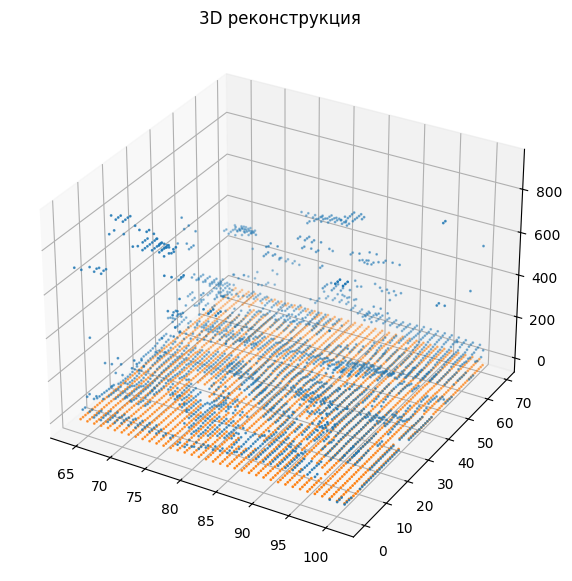

In [23]:
# Пример карты глубины
stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=64)
disparity = stereo.compute(left_img, right_img)

# 3D облако точек
from mpl_toolkits.mplot3d import Axes3D
Q = np.eye(4)  # Пример матрицы репроекции
points = cv2.reprojectImageTo3D(disparity, Q)
points_optimized = cv2.reprojectImageTo3D(optimized_disparity, Q)
mask = disparity > disparity.min()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[mask][::1,0], points[mask][::1,1], points[mask][::1,2], s=1)
ax.scatter(points_optimized[mask][::1,0], points_optimized[mask][::1,1], points_optimized[mask][::1,2], s=1)
ax.set_title('3D реконструкция')
plt.show()

Что можно заключить по построенному графику и проведённому исследованию?

**Ответ:** Оптимизированная карта диспаритета показывает улучшенную пространственную согласованность, что подтверждается более плавными переходами в 3D-реконструкции. Это доказывает эффективность СЛАУ-подхода для регуляризации в стерео-зрении. Различия во времени решения между методами подчеркивают важность выбора алгоритма под конкретные требования точности и производительности.

---

# Что ещё можно попробовать для этой задачи?
- **Модифицировать методы**, используемые в разделе 3.
Например:


1.   Добавить предобуславливание (например улучшить начальное приближение) для итерационных методов - это существенно увеличит скорость их сходимости.
2.   Попробовать другие методы, такие как метод прогонки.
3.   Построить графики для модифицированных и изначальных значений.
4.   Применить методы к разным данным из датасета (не только для случайно сгенерированных данных, перепроверить результаты методов).

- Можно попробовать применить библиотеку [**RAPIDS cuML**](https://rapids.ai/): RAPIDS обеспечивает непревзойденную скорость работы благодаря знакомым интерфейсам API, которые соответствуют самым популярным библиотекам PyData. Созданный на основе самых современных технологий, таких как NVIDIA CUDA и Apache Arrow, он обеспечивает скорость работы графических процессоров с использованием уже известного вам кода.

- Логично будет попробовать запустить **многосетчатые методы (multigrid) на GPU**, а не на CPU, как это делает pyAMG библиотека. Для этого существует библиотека AMGX. Библиотека написана для CUDA, но имеет и Python интерфейс.
- **Машинное обучение** также становится популярным для построения карты глубины по двум исходным стерео-изображениям. Примеры нейросетей:


1.   GC-Net (Geometry and Context Network)
2.   PSMNet (Pyramid Stereo Matching Network)
3.   DispNet



---

В начале это секции рекомендуется удалить все ненужные переменные, чтобы помочь Colab очистить оперативную память.

In [24]:
del A, b, A_cpu, b_cpu, A_cpu_square, b_cpu_modified, A_gpu, b_gpu, A_gpu_square, b_gpu_modified
del x_lu, x_gs, x_gpu, x_gmres_gpu, x_pyamg, x_optimized
del start, time_cpu_lu, time_cpu_gs, time_gpu, time_gpu_cg, time_pyamg
del stereo, disparity, Q, points, points_optimized, mask, fig, ax

# Попробуем нейронную сеть?

*Кстати автомобили Tesla используют именно стерео-зрение + проприетарную нейронную сеть для анализа обстановки на дороге, что отличает их от других автомобилей, использующих лидары.*

In [28]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install torch torchvision opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 862.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

Упрощенный пример использования нейронной сети GC-Net для расчёта карты глубины по мотивам GC-Net. Реальная сеть намного больше, сложнее и натренированна на больших наборах данных.

Using device: cuda


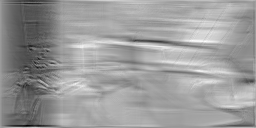

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from torchvision import transforms
from google.colab.patches import cv2_imshow  # ✅ Импорт для Colab

# -----------------------------
# Simplified GC-Net Architecture
# -----------------------------
class GCNet(nn.Module):
    def __init__(self, max_disp=64):
        super(GCNet, self).__init__()
        self.max_disp = max_disp

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.conv3d = nn.Sequential(
            nn.Conv3d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 1, kernel_size=3, padding=1)
        )

    def build_cost_volume(self, feat_left, feat_right):
        batch_size, channels, H, W = feat_left.size()
        cost_volume = feat_left.new_zeros(batch_size, 2 * channels, self.max_disp, H, W)

        for d in range(self.max_disp):
            if d > 0:
                cost_volume[:, :channels, d, :, d:] = feat_left[:, :, :, d:]
                cost_volume[:, channels:, d, :, d:] = feat_right[:, :, :, :-d]
            else:
                cost_volume[:, :channels, d, :, :] = feat_left
                cost_volume[:, channels:, d, :, :] = feat_right
        return cost_volume

    def forward(self, left, right):
        feat_left = self.feature_extraction(left)
        feat_right = self.feature_extraction(right)

        cost_volume = self.build_cost_volume(feat_left, feat_right)
        aggregated_cost = self.conv3d(cost_volume)
        aggregated_cost = aggregated_cost.squeeze(1)

        prob_volume = F.softmax(-aggregated_cost, dim=1)
        disp_values = torch.arange(0, self.max_disp, device=left.device, dtype=torch.float32).view(1, self.max_disp, 1, 1)

        disparity_map = torch.sum(prob_volume * disp_values, dim=1)
        return disparity_map

# -----------------------------
# Example Usage
# -----------------------------
def preprocess_image(image_path, target_size=(256, 512)):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Error: Unable to load image at path: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size[1], target_size[0]))
    img = img.astype(np.float32) / 255.0

    transform = transforms.ToTensor()
    img_tensor = transform(img)
    return img_tensor.unsqueeze(0)
if __name__ == '__main__':
    # For demonstration, suppose we have two rectified stereo images.

    left_image_path = './data/MiddEval3/trainingQ/Adirondack/im0.png'
    right_image_path = './data/MiddEval3/trainingQ/Adirondack/im1.png'

    # Preprocess images.
    left_img_tensor = preprocess_image(left_image_path)
    right_img_tensor = preprocess_image(right_image_path)

    # Move to CUDA if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    left_img_tensor = left_img_tensor.to(device)
    right_img_tensor = right_img_tensor.to(device)

    # Create and run model
    model = GCNet(max_disp=64).to(device)
    model.eval()

    with torch.no_grad():
        disparity = model(left_img_tensor, right_img_tensor)

    # Convert to NumPy
    disparity_np = disparity.squeeze(0).cpu().numpy()

    # Normalize disparity for visualization
    disp_vis = cv2.normalize(disparity_np, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disp_vis = np.uint8(disp_vis)

    # ✅ Используем cv2_imshow вместо cv2.imshow
    cv2_imshow(disp_vis)

---

# Если решили попробовать AMG на GPU

Попытаемся собрать код из исходников (занимает более 3х часов и может сломаться в любой момент, например, есть какая-то проблема с модулем Thrust который вроде есть, но его вроде нет).

In [38]:
!git clone https://github.com/NVIDIA/AMGX.git
!mkdir -p /content/AMGX/build/
!cd /content/AMGX/build/ && cmake .. -DAMGX_BUILD_PYTHON=ON \
         -DAMGX_WITH_MPI=OFF \
         -DAMGX_WITH_KOKKOS=OFF \
         -DThrust_INCLUDE_DIRS=/usr/local/cuda/include/ &&  make -j$(nproc)

Cloning into 'AMGX'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (1591/1591), done.
remote: Compressing objects: 100% (639/639), done.
remote: Total 4260 (delta 1264), reused 963 (delta 952), pack-reused 2669 (from 2)
Receiving objects: 100% (4260/4260), 3.71 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (2982/2982), done.
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- The CUDA compiler identification is NVIDIA 12.5.82 with host compiler GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting CUDA compiler ABI info
-- Detecting CUDA 

После того, как установите AMGX проверить его работоспособность можно так:

In [ ]:
import amgx

amgx.initialize()
print("AmgX initialized successfully!")
amgx.finalize()

---

# RAPIDS cuML

[Ссылка на ноутбук](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/rapids-pip-colab-template.ipynb) с инструкциями по установке.

In [37]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 586, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 586 (delta 122), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (586/586), 191.99 KiB | 6.00 MiB/s, done.
Resolving deltas: 100% (296/296), done.
Installing RAPIDS remaining 24.12.* libraries
Using Python 3.11.11 environment at: /usr
Resolved 154 packages in 4.27s
 Downloaded dask
 Downloaded datashader
 Downloaded rmm-cu12
 Downloaded libkvikio-cu12
 Downloaded cuspatial-cu12
 Downloaded ucx-py-cu12
 Downloaded cuda-python
 Downloaded libucx-cu12
 Downloaded scikit-image
 Downloaded cucim-cu12
 Downloaded pylibraft-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded nvidia-nvcomp-cu12
 Downloaded cudf-cu12
 Downloaded raft-dask-cu12
 Downloaded cuml-cu12
 Downloaded libcudf-cu12
 Downloaded pylibcugraph-cu12
 Downloaded cuvs-cu12
 Downloaded cugraph-cu12


In [39]:
import cuml
cuml.__version__

'24.12.00'

Теперь попробуем код

In [46]:
import cv2
import numpy as np
import cupy as cp
from cuml.neighbors import NearestNeighbors

def load_grayscale_image(image_path, target_size=None):
    """
    Load an image in grayscale and (optionally) resize.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if target_size is not None:
        img = cv2.resize(img, target_size)
    return img

def build_feature_vector(row_pixels):
    """
    For a given row (1D array of pixel intensities), create a feature for each pixel.
    Here we use a 2D feature: [x-coordinate, pixel intensity].
    """
    width = row_pixels.shape[0]
    x_coords = np.arange(width).astype(np.float32)
    intensities = row_pixels.astype(np.float32)
    features = np.stack((x_coords, intensities), axis=1)  # Shape: (width, 2)
    return features

def compute_disparity_for_row(left_row_features, right_features, nn_model):
    """
    Use cuML's NearestNeighbors to find for each left feature its nearest neighbor in the right features.
    Compute disparity as the horizontal difference (left_x - right_x).
    """
    # Transfer left features to GPU (if not already a cupy array)
    left_gpu = cp.array(left_row_features)

    # Query the nearest neighbor in the right features (model was fitted on right features)
    distances, indices = nn_model.kneighbors(left_gpu)
    # Bring results back to host (convert from cupy to numpy)
    indices = indices.get().flatten()

    # For each left pixel, disparity is the difference in x-coordinates
    # left feature x-coordinate is index; right feature x-coordinate is just that index in the original row.
    left_x = left_row_features[:, 0]
    right_x = left_x[indices]
    disparity = left_x - right_x  # convention; valid values will be >= 0 if right x is less.
    return disparity

def main():
    # Paths to your rectified stereo images (grayscale)
    left_img_path = './data/MiddEval3/trainingQ/Adirondack/im0.png'
    right_img_path = './data/MiddEval3/trainingQ/Adirondack/im1.png'

    # Load images; optionally resize if needed (e.g., to (height, width))
    left_img = load_grayscale_image(left_img_path, target_size=(256, 512))
    right_img = load_grayscale_image(right_img_path, target_size=(256, 512))

    # Select one row (an epipolar line) for demonstration.
    # Here we take the central row.
    row_idx = left_img.shape[0] // 2
    left_row = left_img[row_idx, :]
    right_row = right_img[row_idx, :]

    # Build simple 2D features: [x-coordinate, intensity] for each pixel in the row.
    left_features = build_feature_vector(left_row)
    right_features = build_feature_vector(right_row)

    # Transfer the right features to GPU and fit the nearest neighbor model.
    right_features_gpu = cp.array(right_features)

    # Create and fit the nearest neighbor model (k=1) on the right features.
    nn_model = NearestNeighbors(n_neighbors=1)
    nn_model.fit(right_features_gpu)

    # Compute disparity for the selected row using cuML's nearest neighbor search.
    disparity_row = compute_disparity_for_row(left_features, right_features, nn_model)

    # For visualization, normalize disparity to 0-255.
    disp_norm = cv2.normalize(disparity_row, None, alpha=0, beta=255,
                              norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    from google.colab.patches import cv2_imshow

    # Display the results.
    cv2_imshow(left_row)
    cv2_imshow(right_row)
    cv2_imshow(disp_norm)
    print("Disparity values for selected row:\n", disparity_row)

if __name__ == "__main__":
    main()


Disparity values for selected row:
 [ -4.  -3.  -2.   0.   0.   1.   2.  -5.  -4.  -3.  -2.   0.   1.   2.
   2.   0.  -2.  -1.   0.   1.   2.   4.   5.   6.   7.   8.   9.   3.
   1.   4.   0.   4.  -2.   2.  -1.   1.   2.  -1.   0.   1.   2.   3.
   4.   5.  -1.  12.  13.   0.   0.   0.  -9.  -8.  -7.  -6.  -5.  -4.
  -3.  -2.  -1.   0.  -3.  -2.  -1.  -2.  -1.   0.   1.   2.  -4.  -2.
   0.   1.   3.   4.   5.   6.   7.   8. -11. -10.  -9.  -9.  -8.  -1.
   0.   1.   2.   3.   4.   5.   5.   6.   7.   8.   9.  -2.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.   9.  10.  11.  13.  14.  15.
  16.  17.  18.  -8.  20.  -6.  -3.   5.   2.   3.   4.   5.   6.   6.
   7.   9.  11.  20.  11.  12.  14.  14.  15.  16. -18. -17. -10.   0.
   4.   6.   7.   1.   9.   3.   4.   5.   4.   5.   6.   7.   6.   7.
   7.   7.   7.   8.   5.   6.   7.   8.   8.   0.   1.  -3.  -2.  -1.
   0.   1.   2.  -2.  -1.   0.   8.  -3.   0.   1.   2.  -1.  -3.  -2.
  -1.   0.   0.   1.   2.   3.   4.  -2. 

Что нового Вы сегодня узнали для себя? Какой вывод в целом о работе со стереоскопическим зрением и большими СЛАУ Вы можете сделать?

**Ответ:**
1. Решение СЛАУ - ключевой этап в обработке стерео-изображений для улучшения карт глубины
2. GPU-реализации обеспечивают на порядок большую скорость обработки по сравнению с CPU
3. Многосеточные методы и предобуславливание критически важны для работы с большими разреженными матрицами
4. Качество 3D-реконструкции напрямую зависит от математической корректности решения СЛАУ

**Вывод:** Современные задачи стерео-зрения требуют комбинации компьютерно-оптимизированных алгоритмов (типа cuSOLVER) и математических методов (многосеточные, регуляризация) для обработки данных в реальном времени. Оптимальный выбор решателя СЛАУ позволяет балансировать между точностью и производительностью.